# Differential Expression





Calculates differential expression between certain cell type and the rest of cells for the following quantities:

1. normalized mu1 
2. normalized mu2
3. normalized b (burst size)
4. normalized gamma (degradation rate) 


across all genes. 


Uses t-test that does not assume equal variance. 

In [123]:
# System
import sys

# Math
import numpy as np
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
from matplotlib_venn import venn2, venn3

cmap = plt.get_cmap('Purples')


# scvi
import anndata
import scanpy as sc


# stats
from scipy.stats import ttest_ind

In [147]:
matplotlib.rcParams.update({'font.size': 28})

-------

# Function for Differential Expression

In [2]:
def get_bursty_params(mu1,mu2,theta):
    ''' Returns b, beta, gamma of bursty distribution given mu1, mu2 and theta.
    Returns whatever size was input. 
    '''
    
    b = mu1/theta
    beta = 1/theta
    gamma = mu1/(mu2*theta)
    
    
    return(b,beta,gamma)

def perform_ttest(adata,genes,results_dict,cluster_label='subclass_label',setup = 'Bursty-10-NAS_SHAPE',
                   alternative = ['two-sided','less','greater'],
                  permutations = None,subset_index=False,
                 return_dataframe = False):
    ''' Perform three ttests on genes in adata using parameters in results dict. 
    '''
    
    # subset the results_dict and adata if subset != False
    if subset_index != False:
        adata = adata[subset_index]
        norm_means = np.array(results_dict[setup]['norm_means'])[subset_index]
        dispersions = results_dict[setup]['params']['dispersions'][subset_index]
    else:
        norm_means = np.array(results_dict[setup]['norm_means'])
        dispersions = results_dict[setup]['params']['dispersions']
        
    # define dictionaries to hold t and p values
    b_dict = {}
    gamma_dict = {}
    mu1_dict = {}
    mu2_dict = {}
    
    b_dict['genes'] = genes
    gamma_dict['genes'] = genes
    mu1_dict['genes'] = genes
    mu2_dict['genes'] = genes
    
    # define cluster labels
    cluster_labels = np.array(adata.obs[cluster_label].tolist())
    unique_clusters = np.unique(cluster_labels)
    adata_genes = adata.var['gene_name'].tolist()
    
    N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
    
    # arrays to hold parameters
    b = np.ones((len(adata),len(genes)))
    gamma = np.ones((len(adata),len(genes)))
    mu1 = np.ones((len(adata),len(genes)))
    mu2 = np.ones((len(adata),len(genes)))

    
    # loop through genes and calculate parameters
    for i,g in enumerate(genes):
        index = adata_genes.index(g)
        mu1_ = norm_means[:,index]
        mu2_ =  norm_means[:,index+N]
        theta = dispersions[:,index]
    
        b_,beta_,gamma_ = get_bursty_params(mu1_,mu2_,theta)
        b[:,i] = b_
        gamma[:,i] = gamma_
        
        mu1[:,i] = mu1_
        mu2[:,i] = mu2_
            
    for cl in unique_clusters:
        print(cl)
        # subset parameters
        b_cl = b[cluster_labels == cl,:]
        gamma_cl = gamma[cluster_labels == cl,:]
        mu1_cl = mu1[cluster_labels == cl,:]
        mu2_cl = mu2[cluster_labels == cl,:]
        
        b_rest = b[cluster_labels != cl,:]
        gamma_rest = gamma[cluster_labels != cl,:]
        mu1_rest = mu1[cluster_labels != cl,:]
        mu2_rest = mu2[cluster_labels != cl,:]
        
        
        # fold change: av (normalized param in cl/normalized param in rest)
        b_dict[f'{cl} fold change'] = np.mean(b_cl,axis=0)/np.mean(b_rest,axis=0)
        gamma_dict[f'{cl} fold change'] = np.mean(gamma_cl,axis=0)/np.mean(gamma_rest,axis=0)
        mu1_dict[f'{cl} fold change'] = np.mean(mu1_cl,axis=0)/np.mean(mu1_rest,axis=0)
        mu2_dict[f'{cl} fold change'] = np.mean(mu2_cl,axis=0)/np.mean(mu2_rest,axis=0)
        
        # statistics for each parameters
        for alt in alternative:
            statistics_b, pvalues_b = ttest_ind(b_cl, b_rest, axis=0, equal_var= False, 
                              alternative=alt,permutations=permutations)
            statistics_gamma, pvalues_gamma = ttest_ind(gamma_cl, gamma_rest, axis=0, equal_var= False, 
                              alternative=alt,permutations=permutations)
            statistics_mu1, pvalues_mu1 = ttest_ind(mu1_cl, mu1_rest, axis=0, equal_var= False, 
                              alternative=alt,permutations=permutations)
            statistics_mu2, pvalues_mu2 = ttest_ind(mu2_cl, mu2_rest, axis=0, equal_var= False, 
                              alternative=alt,permutations=permutations)
        
            b_dict[f'{cl} t-value, {alt}'] = statistics_b
            gamma_dict[f'{cl} t-value, {alt}'] = statistics_gamma
            mu1_dict[f'{cl} t-value, {alt}'] = statistics_mu1
            mu2_dict[f'{cl} t-value, {alt}'] = statistics_mu2
            
            b_dict[f'{cl} p-value, {alt}'] = pvalues_b
            gamma_dict[f'{cl} p-value, {alt}'] = pvalues_gamma
            mu1_dict[f'{cl} p-value, {alt}'] = pvalues_mu1
            mu2_dict[f'{cl} p-value, {alt}'] = pvalues_mu2
    if return_dataframe == True:
        return(pd.DataFrame(b_dict),pd.DataFrame(gamma_dict),pd.DataFrame(mu1_dict),pd.DataFrame(mu2_dict))
    else:
        return(b_dict,gamma_dict,mu1_dict,mu2_dict)

Load in data. 


In [61]:
name = 'B08_processed_hv'
data_dir = '../../data/allen/'

# read in results file
results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
results_dict = pickle.load(results_file)
results_file.close()

# read in adata
adata = anndata.read_loom(data_dir+f'{name}.loom')
adata.var_names_make_unique()




if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

setups = ['Bursty-10-NAS_SHAPE','scVI-10-NAS_SHAPE']
# remove doublets and SMCs (only ONE SMC cell)
for setup in setups:

    results_dict[setup]['norm_means'] = results_dict[setup]['norm_means'][(adata.obs['subclass_label'] != 'doublet') & (adata.obs['subclass_label'] != 'SMC')]
    results_dict[setup]['params']['mean'] = results_dict[setup]['params']['mean'][(adata.obs['subclass_label'] != 'doublet') & (adata.obs['subclass_label'] != 'SMC')]
    results_dict[setup]['params']['dispersions'] = results_dict[setup]['params']['dispersions'][(adata.obs['subclass_label'] != 'doublet') & (adata.obs['subclass_label'] != 'SMC')]
    
    
adata = adata[(adata.obs['subclass_label'] != 'doublet') & (adata.obs['subclass_label'] != 'SMC')]

# anndata objects for spliced and unspliced counts
adata_s = adata[:,adata.var['Spliced']==1].copy()    
adata_u = adata[:,adata.var['Spliced']==0].copy()


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [62]:
adata

View of AnnData object with n_obs × n_vars = 6417 × 4000
    obs: 'Cell Type', 'barcode', 'class_label', 'cluster_id', 'cluster_label', 'obs_names', 'subclass_label'
    var: 'Spliced', 'dispersions', 'dispersions_norm', 'gene_id', 'gene_name', 'highly_variable', 'means', 'var_names'
    layers: 'counts'

In [67]:
cluster_labels = np.unique(np.array(adata.obs['subclass_label'].unique().tolist()))

--------

# Differential Expression: Standard T-Test 

In [33]:
#two sided test
genes = adata.var['gene_name'].tolist()[:2000] # only need to do once for each gene :) 
b_df_biVI,gamma_df_biVI,mu1_df_biVI,mu2_df_biVI = perform_ttest(adata,genes,results_dict,cluster_label='subclass_label',
                   setup = 'Bursty-10-NAS_SHAPE',alternative = ['two-sided','less','greater'],
                                                   return_dataframe = True)


genes = adata.var['gene_name'].tolist()[:2000] # only need to do once for each gene :) 
b_df_scVI,gamma_df_scVI,mu1_df_scVI,mu2_df_scVI = perform_ttest(adata,genes,results_dict,cluster_label='subclass_label',
                   setup = 'scVI-10-NAS_SHAPE',alternative = ['two-sided','less','greater'],
                                                   return_dataframe = True)

Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Macrophage
OPC
Oligo
Pvalb
Sncg
Sst
VLMC
Vip
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Macrophage
OPC
Oligo
Pvalb
Sncg
Sst
VLMC
Vip


### Significance vs. Fold Change

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


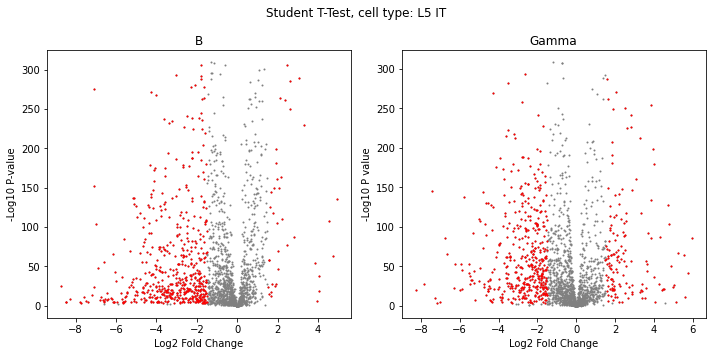

In [34]:
cell_type = 'L5 IT'

fig, ax = plt.subplots(1,2,figsize = (10,5))


FC = 1.5
PVal = -np.log10(0.025/20)
sig_gamma = (abs(np.log2(gamma_df_biVI[f'{cell_type} fold change']))>FC) & (-np.log10(gamma_df_biVI[f'{cell_type} p-value, two-sided'])>PVal)
sig_b = (abs(np.log2(b_df_biVI[f'{cell_type} fold change']))>FC) & (-np.log10(b_df_biVI[f'{cell_type} p-value, two-sided'])>PVal)
                                                                              
                                                                                                                                                          
                                                                              
ax[0].scatter(np.log2(b_df_biVI[f'{cell_type} fold change']),
              -np.log10(b_df_biVI[f'{cell_type} p-value, two-sided']),s=1,c='gray')
ax[0].scatter(np.log2(b_df_biVI[f'{cell_type} fold change'])[sig_b],
              -np.log10(b_df_biVI[f'{cell_type} p-value, two-sided'])[sig_b],s=1,c='red')
ax[0].set_xlabel('Log2 Fold Change')
ax[0].set_ylabel('-Log10 P-value')
ax[0].set_title('B')



ax[1].scatter(np.log2(gamma_df_biVI[f'{cell_type} fold change']),
              -np.log10(gamma_df_biVI[f'{cell_type} p-value, two-sided']),s=1,c='gray')
ax[1].scatter(np.log2(gamma_df_biVI[f'{cell_type} fold change'])[sig_gamma],
              -np.log10(gamma_df_biVI[f'{cell_type} p-value, two-sided'])[sig_gamma],s=1,c='red')
ax[1].set_xlabel('Log2 Fold Change')
ax[1].set_ylabel('-Log10 P value')
ax[1].set_title('Gamma')

plt.suptitle(f'Student T-Test, cell type: {cell_type}')

plt.tight_layout();

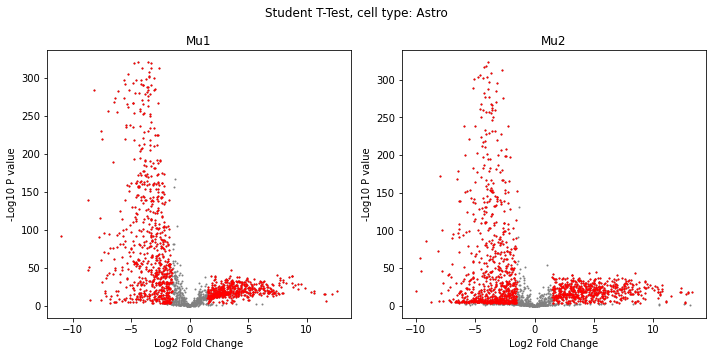

In [35]:
cell_type = 'Astro'

fig, ax = plt.subplots(1,2,figsize = (10,5))


FC = 1.5
PVal = -np.log10(0.025/20)
sig_mu1 = (abs(np.log2(mu1_df_scVI[f'{cell_type} fold change']))>FC) & (-np.log10(mu1_df_scVI[f'{cell_type} p-value, two-sided'])>PVal)
sig_mu2 = (abs(np.log2(mu2_df_scVI[f'{cell_type} fold change']))>FC) & (-np.log10(mu2_df_scVI[f'{cell_type} p-value, two-sided'])>PVal)
                                                                              
                                                                                                                                                          
                                                                              
ax[0].scatter(np.log2(mu1_df_scVI[f'{cell_type} fold change']),
          -np.log10(mu1_df_scVI[f'{cell_type} p-value, two-sided']),s=1,c='gray')
ax[0].scatter(np.log2(mu1_df_scVI[f'{cell_type} fold change'])[sig_mu1],
              -np.log10(mu1_df_scVI[f'{cell_type} p-value, two-sided'])[sig_mu1],s=1,c='red')
ax[0].set_xlabel('Log2 Fold Change')
ax[0].set_ylabel('-Log10 P value')
ax[0].set_title('Mu1')



ax[1].scatter(np.log2(mu2_df_scVI[f'{cell_type} fold change']),
              -np.log10(mu2_df_scVI[f'{cell_type} p-value, two-sided']),s=1,c='gray')
ax[1].scatter(np.log2(mu2_df_scVI[f'{cell_type} fold change'])[sig_mu2],
              -np.log10(mu2_df_scVI[f'{cell_type} p-value, two-sided'])[sig_mu2],s=1,c='red')
ax[1].set_xlabel('Log2 Fold Change')
ax[1].set_ylabel('-Log10 P value')
ax[1].set_title('Mu2')

plt.suptitle(f'Student T-Test, cell type: {cell_type}')

plt.tight_layout();

In [37]:


N = 19 # number of tests performed
FC = 2.0



# store significant differentially expressed genes
sig_dict = {ct : {} for ct in cluster_labels}

for ct in cluster_labels:
    b_index = (b_df_biVI[f'{ct} p-value, two-sided'] < 0.025/N) & (abs(b_df_biVI[f'{ct} fold change']) > FC)
    b_genes = list(b_df_biVI[b_index].genes)
    
    gamma_index = (gamma_df_biVI[f'{ct} p-value, two-sided'] < 0.025/N) & (abs(gamma_df_biVI[f'{ct} fold change']) > FC)
    gamma_genes = list(gamma_df_biVI[gamma_index].genes)
    
    mu1_index = (mu1_df_scVI[f'{ct} p-value, two-sided'] < 0.025/N) & (abs(mu1_df_scVI[f'{ct} fold change']) > FC)
    mu1_genes = list(mu1_df_scVI[mu1_index].genes)
    
    
    mu2_index = (mu2_df_scVI[f'{ct} p-value, two-sided'] < 0.025/N) & (abs(mu2_df_scVI[f'{ct} fold change']) > FC)
    mu2_genes = list(mu2_df_scVI[mu2_index].genes)
    
    biVI_no_mu2_genes = [g for g in genes if (g in b_genes or g in gamma_genes) & (g not in mu2_genes)]
    biVI_genes = [g for g in genes if (g in b_genes or g in gamma_genes) & (g not in mu1_genes and g not in mu2_genes)]
    scVI_genes = [g for g in genes if (g not in b_genes and g not in gamma_genes) & (g in mu1_genes or g in mu2_genes)]
    
    overlap_genes = [g for g in genes if (g in b_genes or g in gamma_genes) & (g in mu1_genes or g in mu2_genes)]
    
    sig_dict[ct]['b_genes'] = b_genes
    sig_dict[ct]['gamma_genes'] = gamma_genes
    sig_dict[ct]['mu1_genes'] = mu1_genes
    sig_dict[ct]['mu2_genes'] = mu2_genes
    sig_dict[ct]['biVI_genes'] = biVI_genes
    sig_dict[ct]['scVI_genes'] = scVI_genes
    sig_dict[ct]['overlap_genes'] = overlap_genes
    sig_dict[ct]['biVI_no_mu2_genes'] = biVI_no_mu2_genes

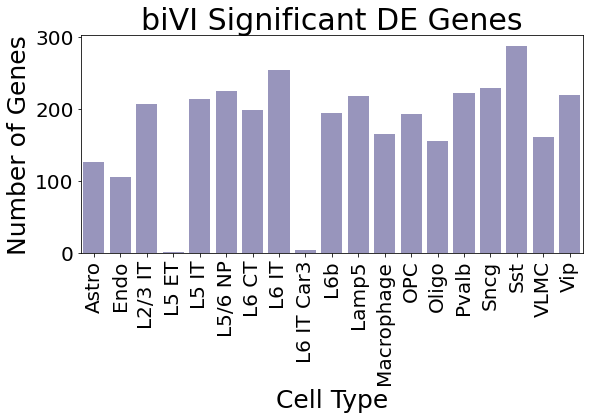

In [126]:
sig_gene_plot = []
sig_gene_scVI = 0
sig_gene_biVI = 0
sig_gene_overlap = 0

for ct in cluster_labels:
    if ct != 'doublet':      
        sig_gene_plot.append(len(sig_dict[ct]['biVI_genes']))
        sig_gene_biVI += len(sig_dict[ct]['biVI_genes'])
        sig_gene_scVI += len(sig_dict[ct]['scVI_genes'])
        sig_gene_overlap += len(sig_dict[ct]['overlap_genes'])
        
plt.figure(figsize=(9,4))
sns.barplot(x=cluster_labels,y = sig_gene_plot,
            palette = [cmap(140) for i in range(19)])
plt.xticks(rotation=90);
plt.xlabel('Cell Type',fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(f'biVI Significant DE Genes',fontsize = 30)
plt.ylabel('Number of Genes',fontsize = 25);
plt.savefig(f'../../results/{name}_figs/biVI_DE_genes.png',bbox_inches='tight')

# Marker Genes

## Are marker genes modified by burst size or degradation rate? 

Or both? 


In [127]:
# store significant differentially expressed genes
compare_b_gamma_dict = {ct : {} for ct in cluster_labels}

for ct in cluster_labels:
    b_X = [g for g in sig_dict[ct]['b_genes'] if g not in sig_dict[ct]['gamma_genes']]
    gamma_X = [g for g in sig_dict[ct]['gamma_genes'] if g not in sig_dict[ct]['b_genes']]
    both = sig_dict[ct]['biVI_genes']
    
    tot = len(b_X)+len(gamma_X)+len(both)
    if tot != 0: 
        compare_b_gamma_dict[ct]['Burst size'] = len(b_X)/tot
        compare_b_gamma_dict[ct]['Relative degradation rate'] = len(gamma_X)/tot
        compare_b_gamma_dict[ct]['Both'] = len(both)/tot
    else:
        compare_b_gamma_dict[ct]['Burst size'] = 0
        compare_b_gamma_dict[ct]['Relative degradation rate'] = 0
        compare_b_gamma_dict[ct]['Both'] = 0

In [40]:
df_ = pd.DataFrame(compare_b_gamma_dict).T.reset_index(inplace=False)
df_1 = pd.DataFrame({'Cell Type' : df_['index'],'Percent' : df_['Burst size'], 'Parameter' : ['Burst size']*19})
df_2 = pd.DataFrame({'Cell Type' : df_['index'],'Percent' : df_['Relative degradation rate'], 'Parameter' : ['Relative degradation rate']*19})
df_3 = pd.DataFrame({'Cell Type' : df_['index'],'Percent' : df_['Both'], 'Parameter' : ['Both']*19})
df_plot = pd.concat([df_1,df_2,df_3],axis=0)


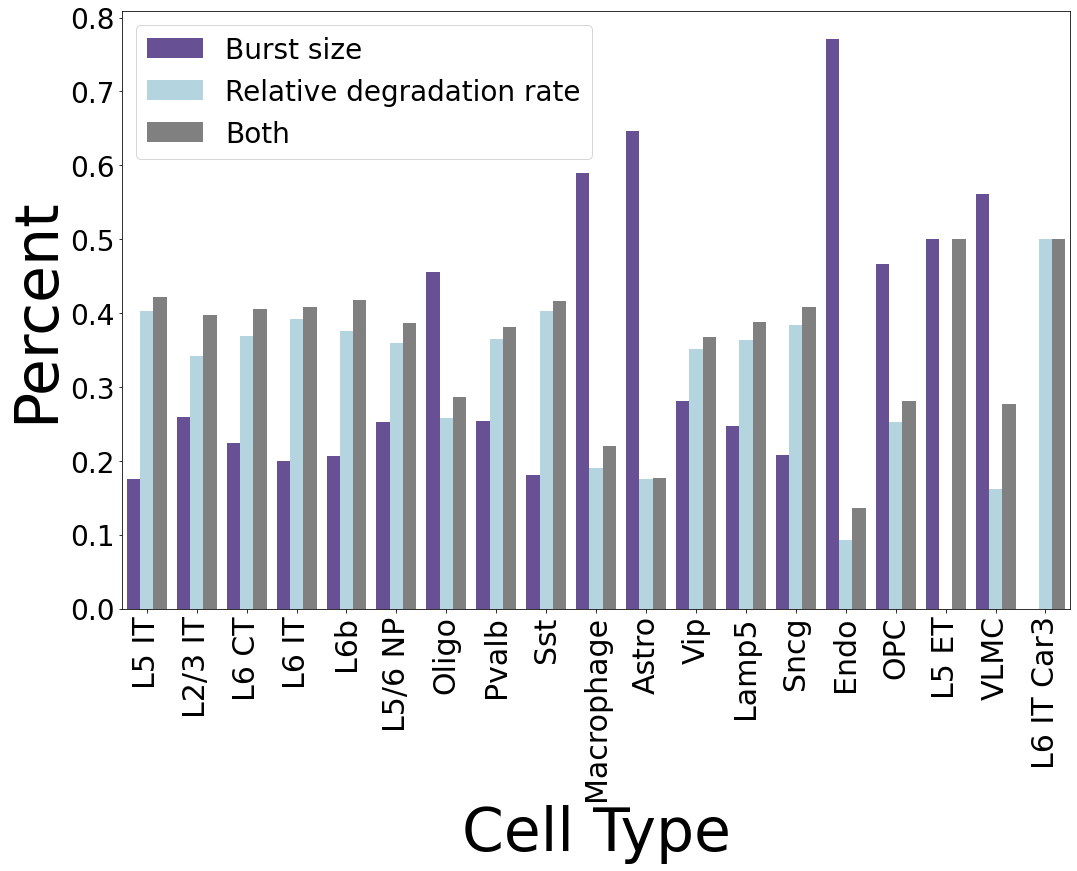

In [155]:

plt.figure(figsize = (17,11))
plt.xticks(rotation = 90, fontsize = 30)
sns.barplot(x='Cell Type', y='Percent', hue='Parameter', data=df_plot, palette = [cmap(200),'lightblue','gray']) 
plt.legend(loc='upper left', )#bbox_to_anchor=(1.0, 0.5),
          #ncol=1, fancybox=True)
plt.xlabel('Cell Type',fontsize = 60)
plt.ylabel('Percent',fontsize = 60)
plt.savefig(f'../../results/{name}_figs/b_gamma_percent.png',bbox_inches='tight')

In [56]:

cell_type = 'L6 CT'
sig_and_abundant_L5_IT = []
genes = adata.var.gene_name
print(f'working with cell type: {cell_type}')
#print(f'working with gene: {adata[1,gene].var.gene_name}')

for gene_name in sig_dict[cell_type]['biVI_genes']:

# select gene
    
    gene = np.where(genes == gene_name)[0][0]
# subset matrix to get spiced/unspliced counts
    spliced_counts = adata_s[adata_s.obs['Cell Type']==cell_type,adata_u.var['gene_name']==gene_name].layers['counts'].todense()
    unspliced_counts = adata_u[adata_u.obs['Cell Type']==cell_type,adata_s.var['gene_name']==gene_name].layers['counts'].todense()
# spliced_counts = adata_s[adata_s.obs['Cell Type']==cell_type,gene].layers['counts'].todense()
# unspliced_counts = adata_u[adata_u.obs['Cell Type']==cell_type,gene].layers['counts'].todense()



# create matrix of observed counts
    observed_counts = np.ones((spliced_counts.shape[0],2))
    observed_counts[:,0] = unspliced_counts.flatten()
    observed_counts[:,1] = spliced_counts.flatten()


    nonzero_u = spliced_counts[unspliced_counts > 0].shape[1]
    nonzero_s = spliced_counts[spliced_counts > 0].shape[1]
    
    if nonzero_u > 100 and nonzero_s > 100:
        sig_and_abundant_L5_IT.append(gene_name)
        

working with cell type: L6 CT


In [57]:
sig_and_abundant_L5_IT

['Lamp5', 'Arhgap29', 'Ttc28', 'Cux2', 'Il18']

-----------------

# Differential Expression: Permutations

Is the assumption of normally distributed parameters valid? 

If not, a t-test is not a good test to perform and we should perform some non-parametric hypothesis test.


In [294]:
norm_means = np.array(results_dict['Bursty-10-NAS_SHAPE']['norm_means'])

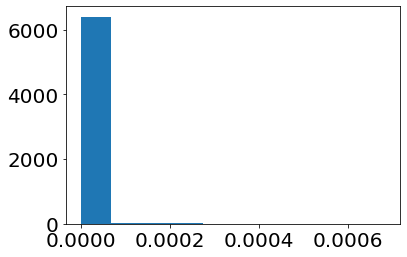

In [295]:
plt.hist(norm_means[:,0],bins=10);

In [303]:
b_dict,gamma_dict,mu1_dict,mu2_dict = perform_ttest(adata,genes,results_dict,cluster_label='subclass_label',
                   setup = 'Bursty-10-NAS_SHAPE',alternative = ['two-sided','less','greater'],
                                                    permutations=10)

Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Macrophage
OPC
Oligo
Pvalb
SMC


/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:6757: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat_observed = _calc_t_stat(a, b, equal_var, axis=axis)
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:6690: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat.append(_calc_t_stat(a, b, equal_var))


Sncg
Sst
VLMC
Vip
doublet


-------------------

# Wilcoxon Rank Sum Test





Finds the test statistic and p-value between genes in groups using the Wilcoxon Rank Sum Test.

In [319]:
from scipy.stats import ranksums

In [392]:
def perform_ranksumtest(adata,genes,results_dict,cluster_label='subclass_label',setup = 'Bursty-10-NAS_SHAPE',
                   alternative = ['two-sided'],subset_index=False, return_dataframe = False):
    ''' Performs Wilcoxon Rank Sum test on mu1 and mu2 of scVI parameters. 
    '''
    
    # subset the results_dict and adata if subset != False
    if subset_index != False:
        adata = adata[subset_index]
        norm_means = np.array(results_dict[setup]['norm_means'])[subset_index]
        dispersions = results_dict[setup]['params']['dispersions'][subset_index]
    else:
        norm_means = np.array(results_dict[setup]['norm_means'])
        dispersions = results_dict[setup]['params']['dispersions']
        
    # define dictionaries to hold t and p values
    b_dict = {}
    gamma_dict = {}
    mu1_dict = {}
    mu2_dict = {}
    
    b_dict['genes'] = genes
    gamma_dict['genes'] = genes
    mu1_dict['genes'] = genes
    mu2_dict['genes'] = genes
    
    # define cluster labels
    cluster_labels = np.array(adata.obs[cluster_label].tolist())
    unique_clusters = np.unique(cluster_labels)
    adata_genes = adata.var['gene_name'].tolist()
    
    N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
    
    # arrays to hold parameters
    b = np.ones((len(adata),len(genes)))
    gamma = np.ones((len(adata),len(genes)))
    mu1 = np.ones((len(adata),len(genes)))
    mu2 = np.ones((len(adata),len(genes)))

    
    # loop through genes and calculate parameters
    for i,g in enumerate(genes):
        index = adata_genes.index(g)
        mu1_ = norm_means[:,index]
        mu2_ =  norm_means[:,index+N]
        theta = dispersions[:,index]
    
        b_,beta_,gamma_ = get_bursty_params(mu1_,mu2_,theta)
        b[:,i] = b_
        gamma[:,i] = gamma_
        
        mu1[:,i] = mu1_
        mu2[:,i] = mu2_
            
    for cl in unique_clusters:
        print(cl)
        # subset parameters
        b_cl = b[cluster_labels == cl,:]
        gamma_cl = gamma[cluster_labels == cl,:]
        mu1_cl = mu1[cluster_labels == cl,:]
        mu2_cl = mu2[cluster_labels == cl,:]
        
        b_rest = b[cluster_labels != cl,:]
        gamma_rest = gamma[cluster_labels != cl,:]
        mu1_rest = mu1[cluster_labels != cl,:]
        mu2_rest = mu2[cluster_labels != cl,:]
        
        
        # fold change: av (normalized param in cl/normalized param in rest)
        b_dict[f'{cl} fold change'] = np.mean(b_cl,axis=0)/np.mean(b_rest,axis=0)
        gamma_dict[f'{cl} fold change'] = np.mean(gamma_cl,axis=0)/np.mean(gamma_rest,axis=0)
        mu1_dict[f'{cl} fold change'] = np.mean(mu1_cl,axis=0)/np.mean(mu1_rest,axis=0)
        mu2_dict[f'{cl} fold change'] = np.mean(mu2_cl,axis=0)/np.mean(mu2_rest,axis=0)
        
        # statistics for each parameters
        for alt in alternative:
            statistics_b, pvalues_b = ranksums(b_cl, b_rest, axis=0,
                              alternative=alt)
            statistics_gamma, pvalues_gamma = ranksums(gamma_cl, gamma_rest, axis=0,
                              alternative=alt)
            statistics_mu1, pvalues_mu1 = ranksums(mu1_cl, mu1_rest, axis=0,
                              alternative=alt)
            statistics_mu2, pvalues_mu2 = ranksums(mu2_cl, mu2_rest, axis=0,
                              alternative=alt)
        
            b_dict[f'{cl} t-value, {alt}'] = statistics_b
            gamma_dict[f'{cl} t-value, {alt}'] = statistics_gamma
            mu1_dict[f'{cl} t-value, {alt}'] = statistics_mu1
            mu2_dict[f'{cl} t-value, {alt}'] = statistics_mu2
            
            b_dict[f'{cl} p-value, {alt}'] = pvalues_b
            gamma_dict[f'{cl} p-value, {alt}'] = pvalues_gamma
            mu1_dict[f'{cl} p-value, {alt}'] = pvalues_mu1
            mu2_dict[f'{cl} p-value, {alt}'] = pvalues_mu2

    if return_dataframe == True:
        return(pd.DataFrame(b_dict),pd.DataFrame(gamma_dict),pd.DataFrame(mu1_dict),pd.DataFrame(mu2_dict))
    else:
        return(b_dict,gamma_dict,mu1_dict,mu2_dict)

In [402]:
# perform rank sum test
#two sided test
genes = adata.var['gene_name'].tolist()[:2000] # only need to do once for each gene :) 
b_df_biVI_W,gamma_df_biVI_W,mu1_df_biVI_W,mu2__df_biVI_W = perform_ranksumtest(adata,genes,results_dict,cluster_label='subclass_label',
                   setup = 'Bursty-10-NAS_SHAPE',alternative = ['two-sided'], return_dataframe = True)


b_df_scVI_W,gamma_df_scVI_W,mu1_df_scVI_W,mu2_df_scVI_W = perform_ranksumtest(adata,genes,results_dict,cluster_label='subclass_label',
                   setup = 'scVI-10-NAS_SHAPE',alternative = ['two-sided'], return_dataframe = True)

Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Macrophage
OPC
Oligo
Pvalb
SMC
Sncg
Sst
VLMC
Vip
doublet
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Macrophage
OPC
Oligo
Pvalb
SMC
Sncg
Sst
VLMC
Vip
doublet


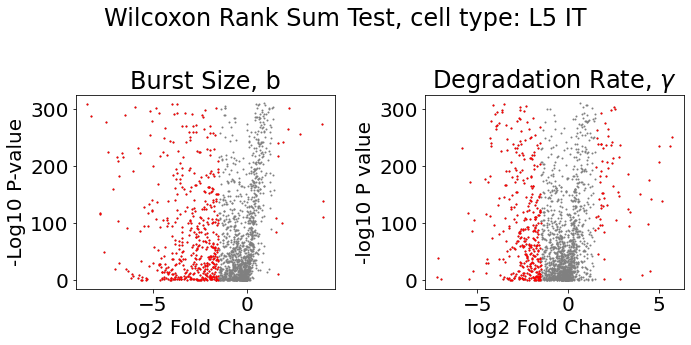

In [406]:
cell_type = 'L5 IT'

fig, ax = plt.subplots(1,2,figsize = (10,5))


FC = 1.5
PVal = np.log(0.025/20)
sig_gamma = (abs(np.log2(gamma_df_biVI_W[f'{cell_type} fold change']))>FC) & (-np.log10(gamma_df_biVI_W[f'{cell_type} p-value, two-sided'])>PVal)
sig_b = (abs(np.log2(b_df_biVI_W[f'{cell_type} fold change']))>FC) & (-np.log10(b_df_biVI_W[f'{cell_type} p-value, two-sided'])>PVal)
                                                                              
                                                                                                                                                          
                                                                              
ax[0].scatter(np.log2(b_df_biVI_W[f'{cell_type} fold change']),
              -np.log10(b_df_biVI_W[f'{cell_type} p-value, two-sided']),s=1,c='gray')
ax[0].scatter(np.log2(b_df_biVI_W[f'{cell_type} fold change'])[sig_b],
              -np.log10(b_df_biVI_W[f'{cell_type} p-value, two-sided'])[sig_b],s=1,c='red')
ax[0].set_xlabel('Log2 Fold Change')
ax[0].set_ylabel('-Log10 P-value')
ax[0].set_title('Burst Size, b')



ax[1].scatter(np.log2(gamma_df_biVI_W[f'{cell_type} fold change']),
              -np.log10(gamma_df_biVI_W[f'{cell_type} p-value, two-sided']),s=1,c='gray')
ax[1].scatter(np.log2(gamma_df_biVI_W[f'{cell_type} fold change'])[sig_gamma],
              -np.log10(gamma_df_biVI_W[f'{cell_type} p-value, two-sided'])[sig_gamma],s=1,c='red')
ax[1].set_xlabel('log2 Fold Change')
ax[1].set_ylabel('-log10 P value')
ax[1].set_title('Degradation Rate, $\gamma$')


plt.suptitle(f'Wilcoxon Rank Sum Test, cell type: {cell_type}')

plt.tight_layout();

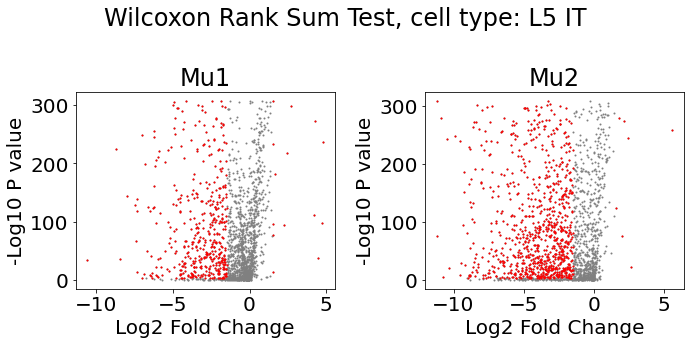

In [409]:
cell_type = 'L5 IT'

fig, ax = plt.subplots(1,2,figsize = (10,5))


FC = 1.5
PVal = -np.log10(0.025/20)
sig_mu1 = (abs(np.log2(mu1_df_scVI_W[f'{cell_type} fold change']))>FC) & (-np.log10(mu1_df_scVI_W[f'{cell_type} p-value, two-sided'])>PVal)
sig_mu2 = (abs(np.log2(mu2__df_scVI_W[f'{cell_type} fold change']))>FC) & (-np.log10(mu2__df_scVI_W[f'{cell_type} p-value, two-sided'])>PVal)
                                                                              
                                                                                                                                                          
                                                                              
ax[0].scatter(np.log2(mu1_df_scVI_W[f'{cell_type} fold change']),
          -np.log10(mu1_df_scVI_W[f'{cell_type} p-value, two-sided']),s=1,c='gray')
ax[0].scatter(np.log2(mu1_df_scVI_W[f'{cell_type} fold change'])[sig_mu1],
              -np.log10(mu1_df_scVI_W[f'{cell_type} p-value, two-sided'])[sig_mu1],s=1,c='red')
ax[0].set_xlabel('Log2 Fold Change')
ax[0].set_ylabel('-Log10 P value')
ax[0].set_title('Mu1')



ax[1].scatter(np.log2(mu2__df_scVI_W[f'{cell_type} fold change']),
              -np.log10(mu2__df_scVI_W[f'{cell_type} p-value, two-sided']),s=1,c='gray')
ax[1].scatter(np.log2(mu2__df_scVI_W[f'{cell_type} fold change'])[sig_mu2],
              -np.log10(mu2__df_scVI_W[f'{cell_type} p-value, two-sided'])[sig_mu2],s=1,c='red')
ax[1].set_xlabel('Log2 Fold Change')
ax[1].set_ylabel('-Log10 P value')
ax[1].set_title('Mu2')

plt.suptitle(f'Wilcoxon Rank Sum Test, cell type: {cell_type}')

plt.tight_layout();



-------


# Venn Diagram Comparisons 

In [425]:

N = 20 # number of tests performed


cluster_labels = np.unique(np.array(adata.obs['subclass_label'].tolist()))

# store significant differentially expressed genes
sig_dict_W = {ct : {} for ct in cluster_labels}

for ct in cluster_labels:
    b_genes = list(b_df_biVI_W[b_df_biVI_W[f'{ct} p-value, two-sided'] < 0.025/N].genes)
    
    gamma_genes = list(gamma_df_biVI_W[gamma_df_biVI_W[f'{ct} p-value, two-sided'] < 0.025/N].genes)
    
    mu1_genes = list(mu1_df_scVI_W[mu1_df_scVI_W[f'{ct} p-value, two-sided'] < 0.025/N].genes)
    mu2_genes = list(mu2__df_scVI_W[mu2__df_scVI_W[f'{ct} p-value, two-sided'] < 0.025/N].genes)
    
    
    biVI_genes = [g for g in genes if (g in b_genes or g in gamma_genes) and (g not in mu1_genes and g not in mu2_genes)]
    scVI_genes = [g for g in genes if (g not in b_genes and g not in gamma_genes) and (g in mu1_genes or g in mu2_genes)]
    
    overlap_genes = [g for g in genes if (g in b_genes or g in gamma_genes) and (g in mu1_genes or g in mu2_genes)]
    
    sig_dict_W[ct]['b_genes'] = b_genes
    sig_dict_W[ct]['gamma_genes'] = gamma_genes
    sig_dict_W[ct]['mu1_genes'] = mu1_genes
    sig_dict_W[ct]['mu2_genes'] = mu2_genes
    sig_dict_W[ct]['biVI_genes'] = biVI_genes
    sig_dict_W[ct]['scVI_genes'] = scVI_genes
    sig_dict_W[ct]['overlap_genes'] = overlap_genes

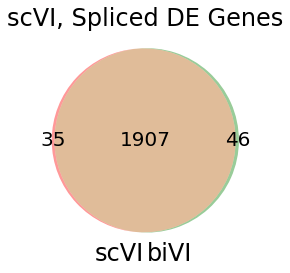

In [439]:
ct = 'L5 IT'


scVI_genes = sig_dict[ct]['mu1_genes'] + [g for g in sig_dict[ct]['mu2_genes'] if g not in sig_dict[ct]['mu1_genes']]
biVI_genes = sig_dict[ct]['b_genes'] + [g for g in sig_dict[ct]['gamma_genes'] if g not in sig_dict[ct]['b_genes']]                                     
                                      
                                      
plt.title('scVI, Spliced DE Genes')
venn2([set(scVI_genes),set(biVI_genes)],['scVI','biVI'])


In [443]:
len(sig_dict_W[ct]['biVI_genes'])

26